## About the CIFAR-10 dataset

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) (classification of small images across 10 distinct classes---airplane, automobile, bird, cat, deer, dog, frog, horse, ship & truck).


![](cifar_10.png)

The CIFAR-10 dataset contains 50000 training examples and 10000 test examples. Each example is a $32 \times 32 \times 32$ pixels coloured image.

# 1. Loading and pre-processing CIFAR-10 dataset


Using TensorFlow backend.


(50000, 32, 32, 3)
(10000, 32, 32, 3)


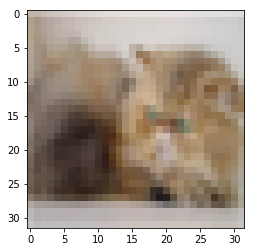

cat


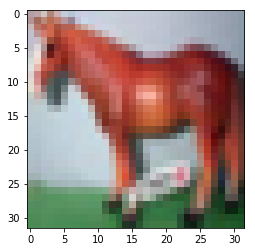

horse


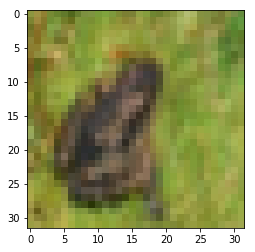

frog
(50000, 3072)
(10000, 3072)
[[ 0.69411767  0.627451    0.65882355 ...,  0.10980392  0.33725491
   0.14901961]
 [ 0.54901963  0.58823532  0.25098041 ...,  0.627451    0.65490198
   0.30980393]
 [ 0.33725491  0.27058825  0.20784314 ...,  0.25098041  0.22352941
   0.14117648]
 [ 0.57647061  0.67843139  0.35686275 ...,  0.3137255   0.26666668
   0.18431373]]


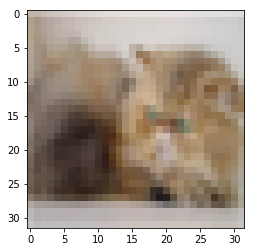

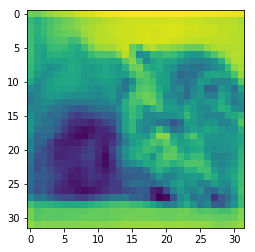

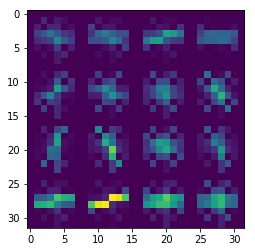

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import itertools
import os
os.environ['KERAS_BACKEND']="tensorflow"

from keras.datasets import cifar10 # subroutines for fetching the CIFAR-10 dataset
from keras.utils import np_utils # utilities for one-hot encoding of ground truth values
from sklearn.utils import shuffle
from skimage import feature
from skimage import data

(X_train_img, y_train), (X_test_img, y_test) = cifar10.load_data() # fetch CIFAR-10 data # dirname="."??
print(X_train_img.shape)
print(X_test_img.shape)
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Shuffle examples
X_train_img, y_train = shuffle(X_train_img, y_train)
X_test_img, y_test = shuffle(X_test_img, y_test)

plt.figure()
plt.imshow(X_train_img[0])
plt.show()
print(class_names[int(y_train[0])])
plt.figure()
plt.imshow(X_train_img[1])
plt.show()
print(class_names[int(y_train[1])])
plt.figure()
plt.imshow(X_train_img[2])
plt.show()
print(class_names[int(y_train[2])])

num_train, depth, height, width = X_train_img.shape # there are 50000 training examples in CIFAR-10 
num_test = X_test_img.shape[0] # there are 10000 test examples in CIFAR-10
num_classes = np.unique(y_train).shape[0] # there are 10 image classes

Y_train = np_utils.to_categorical(y_train, num_classes) # One-hot encode the labels
Y_test = np_utils.to_categorical(y_test, num_classes) # One-hot encode the labels

# Produce a [0;1] normalized "image" for potential input into a convNet
X_train_img_norm = X_train_img.astype('float32') 
X_test_img_norm = X_test_img.astype('float32')
X_train_img_norm /= np.max(X_train_img_norm) # Normalise data to [0, 1] range
X_test_img_norm /= np.max(X_test_img_norm) # Normalise data to [0, 1] range

# Rasterize normalized images into 1D vectors for potential input of raw image into standard ML algo such as kNN, MLP, SVM, etc
X_train_vectNorm = X_train_img_norm.reshape(num_train,height*width*depth)
X_test_vectNorm = X_test_img_norm.reshape(num_test,height*width*depth)

print(X_train_vectNorm.shape)
print(X_test_vectNorm.shape)
print(X_train_vectNorm[1:5])

######################################################
# Compute HOG feature as potential BETTER input into standard ML algo such as kNN, MLP, SVM, etc
from skimage import color

# test sur la 1ère image :
image0 = X_train_img[0]
image0_luminance = color.rgb2gray(image0) ## Il faut supprimer une dimension : on utilise la luminance plutôt que le RGB
plt.figure()
plt.imshow(image0)
plt.show()
plt.figure()
plt.imshow(image0_luminance)
plt.show()
hog0, hog_image0 = feature.hog(color.rgb2gray(image0_luminance), orientations=9, pixels_per_cell=(8, 8), 
                                    cells_per_block=(3, 3), block_norm='L2-Hys', 
                                    visualise=True, transform_sqrt=False, feature_vector=True)
plt.figure()
plt.imshow(hog_image0)
plt.show()

# transformation des images en descripteurs HOG :
XHog_train_img = []
for img in X_train_img :
    hog, hog_image = feature.hog(color.rgb2gray(img), orientations=9, pixels_per_cell=(8, 8), 
                                    cells_per_block=(3, 3), block_norm='L2-Hys', 
                                    visualise=True, transform_sqrt=False, feature_vector=True)
    XHog_train_img.append(hog)
XHog_test_img = []
for img in X_test_img :
    hog, hog_image = feature.hog(color.rgb2gray(img), orientations=9, pixels_per_cell=(8, 8), 
                                    cells_per_block=(3, 3), block_norm='L2-Hys', 
                                    visualise=True, transform_sqrt=False, feature_vector=True)
    XHog_test_img.append(hog)

# Normalisation :
XHog_train_img_norm = np.array(XHog_train_img).astype('float32')
XHog_test_img_norm = np.array(XHog_test_img).astype('float32')
XHog_train_img_norm /= np.max(XHog_train_img_norm) # Normalise data to [0, 1] range
XHog_test_img_norm /= np.max(XHog_test_img_norm) # Normalise data to [0, 1] range


## Une fonction pour afficher graphiquement les matrices de confusion

## Baseline method: kNN on raw normalized pixels

In [2]:
#%matplotlib inline
import matplotlib.pyplot as plt
import itertools

# Definition for the function that plot the confusion matrix
# See : http://www.sci-kit.org/
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 2. Baseline method: kNN on raw normalized pixels

(50000, 1)
[[519   7 109  14  57   7  26   4 252   5]
 [138 174 119  43 179  32  70  10 217  18]
 [102   1 455  37 255  27  58  10  54   1]
 [ 89   6 246 175 213  97 106  17  49   2]
 [ 69   4 253  38 508  20  49   9  50   0]
 [ 67   2 241 141 203 193  76  14  57   6]
 [ 35   1 281  53 335  46 226   2  20   1]
 [113   6 206  47 261  61  60 175  65   6]
 [146  15  52  32  59  15  12   5 659   5]
 [174  48 112  56 111  25  57  27 270 120]]
Normalized confusion matrix
[[ 0.52  0.01  0.11  0.01  0.06  0.01  0.03  0.    0.25  0.01]
 [ 0.14  0.17  0.12  0.04  0.18  0.03  0.07  0.01  0.22  0.02]
 [ 0.1   0.    0.46  0.04  0.26  0.03  0.06  0.01  0.05  0.  ]
 [ 0.09  0.01  0.25  0.17  0.21  0.1   0.11  0.02  0.05  0.  ]
 [ 0.07  0.    0.25  0.04  0.51  0.02  0.05  0.01  0.05  0.  ]
 [ 0.07  0.    0.24  0.14  0.2   0.19  0.08  0.01  0.06  0.01]
 [ 0.04  0.    0.28  0.05  0.34  0.05  0.23  0.    0.02  0.  ]
 [ 0.11  0.01  0.21  0.05  0.26  0.06  0.06  0.17  0.07  0.01]
 [ 0.15  0.01  0.05  0.03 

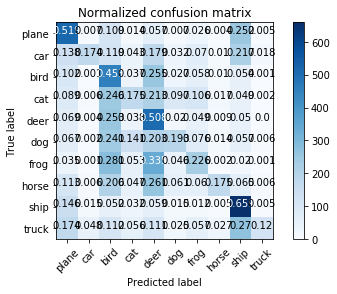

In [3]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix

clf = neighbors.KNeighborsClassifier(n_neighbors=5)
print(y_train.shape)
clf.fit(X_train_vectNorm[:30000], y_train.ravel()[:30000]) # utiliser toutes les données conduit à une Memory Error

y_test_pred_knn = clf.predict(X_test_vectNorm)


cnf_matrix_knn = confusion_matrix(y_test, y_test_pred_knn)
print(cnf_matrix_knn)

np.set_printoptions(precision=2)
plt.figure()
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(cnf_matrix_knn, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

### Remarques sur les résultats :

La matrice de confusion montre des résultats peu convaincants : seules quelques classes ont des valeurs de recall proches de 0.5 (bateaux et avions notamment, peut-être parce ces images possèdent un ciel bleu distinctif). Mais le principal problème est la lenteur de l'algorithme : pour un jeu d'entraînement restreint (30 000 à la place de 50 000), et pour 5 voisins, il tourne pendant plus d'une demi-heure pour donner les mauvais résultats ci-dessus. Nous n'avons donc testé que pour la seule valeur de paramètre de 5 voisins.

# 3. Random Forests

##  3.1. Random forests on raw normalized pixels

n_estimators= 20  max_depth= None max_features= auto
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=1e-07, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy (on test set) =  0.4
             precision    recall  f1-score   support

      plane       0.47      0.55      0.51      1000
        car       0.41      0.50      0.45      1000
       bird       0.30      0.33      0.31      1000
        cat       0.26      0.25      0.25      1000
       deer       0.33      0.33      0.33      1000
        dog       0.35      0.30      0.32      1000
       frog       0.43      0.42      0.43      1000
      horse       0.45      0.35      0.40      1000
       ship     

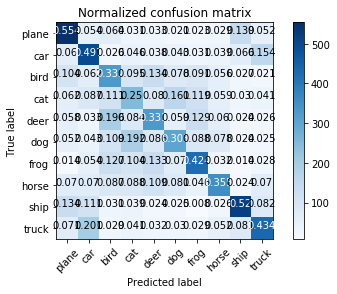

In [4]:
#Random Forests

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Create and train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=20, criterion='gini', max_depth=None,
                             min_samples_split=2, min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, max_features='auto', 
                             max_leaf_nodes=None, min_impurity_decrease=1e-07, bootstrap=True, 
                             oob_score=False, n_jobs=1, random_state=None, 
                             verbose=0, warm_start=False, class_weight=None)
clf = clf.fit(X_train_vectNorm, y_train.ravel())

print("n_estimators=", clf.n_estimators, " max_depth=",clf.max_depth,
      "max_features=", clf.max_features)
print(clf)

# accuracy :
score = clf.score(X_test_vectNorm, y_test)
print("Accuracy (on test set) = ", score)

# resultats et matrice de confusion
y_true, y_pred_rf = y_test, clf.predict(X_test_vectNorm)
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print( classification_report(y_true, y_pred_rf, target_names=class_names) )

print("\n CONFUSION MATRIX")
cnf_matrix_rf=confusion_matrix(y_true, y_pred_rf)
print( cnf_matrix_rf )
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_rf, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

## 3.2. Random forests on HOG descriptors

n_estimators= 20  max_depth= None max_features= auto
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=1e-07, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy (on test set) =  0.3978
             precision    recall  f1-score   support

      plane       0.46      0.49      0.48      1000
        car       0.51      0.55      0.53      1000
       bird       0.28      0.29      0.29      1000
        cat       0.25      0.24      0.25      1000
       deer       0.32      0.48      0.39      1000
        dog       0.32      0.30      0.31      1000
       frog       0.44      0.46      0.45      1000
      horse       0.47      0.31      0.38      1000
       ship  

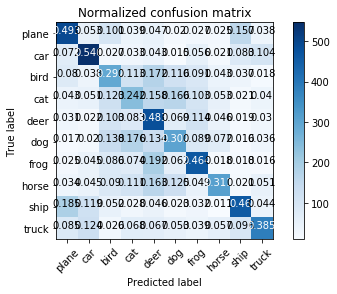

In [5]:
#Random Forests
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Create and train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=20, criterion='gini', max_depth=None,
                             min_samples_split=2, min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, max_features='auto', 
                             max_leaf_nodes=None, min_impurity_decrease=1e-07, bootstrap=True, 
                             oob_score=False, n_jobs=1, random_state=None, 
                             verbose=0, warm_start=False, class_weight=None)
clf = clf.fit(XHog_train_img_norm, y_train.ravel())

print("n_estimators=", clf.n_estimators, " max_depth=",clf.max_depth,
      "max_features=", clf.max_features)
print(clf)

# accuracy :
score = clf.score(XHog_test_img_norm, y_test)
print("Accuracy (on test set) = ", score)

# resultats et matrice de confusion
y_true, y_pred_rf = y_test, clf.predict(XHog_test_img_norm)
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print( classification_report(y_true, y_pred_rf, target_names=class_names) )

print("\n CONFUSION MATRIX")
cnf_matrix_rf=confusion_matrix(y_true, y_pred_rf)
print( cnf_matrix_rf )
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_rf, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

### Comparaison des deux sets de données : images inchangées vs descripteurs HOG

Dans les deux cas (HOG ou pixels), pour le même jeu de paramètres de la forêt aléatoire, les résultats sont sensiblement identiques (*accuracies* très proches, au centième près).
Les descripteurs HOG ne semblent donc pas apporter beaucoup d'informations, mais ils apportent de la rapidité puisque les vecteurs correspondant aux images sont moins volumineux. Néanmoins, les algorithmes tournent bien avec les images directement (on a en effet de petites images avec la base de données CIFAR-10).

Ci-dessous, on effectue une validation croisée avec les descripteurs HOG, dans un souci de temps d'exécution raisonnable.

## 3.3. Random forests - crossvalidation

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=1e-07, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [10, 20, 30, 40], 'criterion': ['entropy', 'gini'], 'max_depth': [None, 3, 5, 10], 'max_features': ['auto', 5, 10, 15]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
Accuracy (on test set) =  0.4451


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.2s finished


             precision    recall  f1-score   support

      plane       0.53      0.52      0.53      1000
        car       0.55      0.56      0.55      1000
       bird       0.35      0.32      0.33      1000
        cat       0.29      0.23      0.26      1000
       deer       0.35      0.56      0.43      1000
        dog       0.36      0.35      0.36      1000
       frog       0.48      0.54      0.50      1000
      horse       0.50      0.40      0.44      1000
       ship       0.52      0.53      0.52      1000
      truck       0.55      0.45      0.50      1000

avg / total       0.45      0.45      0.44     10000


 CONFUSION MATRIX
[[520  44  75  35  58  24  25  29 165  25]
 [ 54 556  12  31  43  14  58  22 100 110]
 [ 76  28 320  75 196 109  95  50  30  21]
 [ 47  48  86 229 167 188 116  56  19  44]
 [ 22  23  77  68 562  51  91  68  23  15]
 [ 13  16 102 162 151 347  98  69  14  28]
 [ 20  34  79  56 178  48 535  16  18  16]
 [ 33  40  73  76 143 118  52 401  19  45

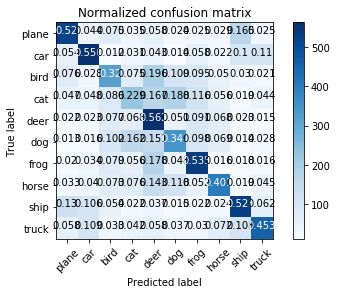

In [48]:
from sklearn.model_selection import GridSearchCV

# Validation croisée :
param_grid = [
  {'n_estimators': [10,20,30,40],
   'criterion': ['entropy','gini'],
   'max_depth':[None,3,5,10],
   'max_features': ['auto',5,10,15]}
 ]

clf = GridSearchCV( RandomForestClassifier(n_estimators=20, criterion='entropy', max_depth=None,
                             min_samples_split=2, min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, max_features='auto', 
                             max_leaf_nodes=None, min_impurity_decrease=1e-07, bootstrap=True, 
                             oob_score=False, n_jobs=1, random_state=None, 
                             verbose=1, warm_start=False, class_weight=None), param_grid)
clf = clf.fit(XHog_train_img_norm, y_train.ravel())

print(clf)

# accuracy :
score = clf.score(XHog_test_img_norm, y_test)
print("Accuracy (on test set) = ", score)

# resultats et matrice de confusion
y_true, y_pred_rf = y_test, clf.predict(XHog_test_img_norm)
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print( classification_report(y_true, y_pred_rf, target_names=class_names) )

print("\n CONFUSION MATRIX")
cnf_matrix_rf=confusion_matrix(y_true, y_pred_rf)
print( cnf_matrix_rf )
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_rf, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

### Conclusion sur les forêts aléatoires :

La validation croisée optimise l'accuracy en choisissant les meilleurs paramètres parmi la liste proposée : le résultat ci-dessus donne cette solution "optimale". Pourtant, l'accuracy est à peine meilleure que celles trouvées précédemment (0.44 vs 0.4).
Bien sûr, les forêts aléatoires pourraient permettre de meilleurs résultats si on les entraînait plus longtemps, en faisant un travail plus approfondi pour choisir les paramètres ; mais le temps d'exécution est très long, en particulier celui d'une validation croisée.

# 4. Multilayer perceptrons

## 4.1 On raw pixel input

### 4.1.1 Training

In [37]:
import os
os.environ['KERAS_BACKEND']="tensorflow"
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(52, input_dim=32*32*3))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_vectNorm, Y_train, epochs=90, batch_size=32)




Epoch 1/90
50000/50000 [==============================] - 6s - loss: 1.9440 - acc: 0.3042     
Epoch 2/90
50000/50000 [==============================] - 5s - loss: 1.7871 - acc: 0.3628     
Epoch 3/90
50000/50000 [==============================] - 5s - loss: 1.7370 - acc: 0.3810     
Epoch 4/90
50000/50000 [==============================] - 5s - loss: 1.7064 - acc: 0.3920     
Epoch 5/90
50000/50000 [==============================] - 5s - loss: 1.6790 - acc: 0.4043     
Epoch 6/90
50000/50000 [==============================] - 5s - loss: 1.6617 - acc: 0.4099     
Epoch 7/90
50000/50000 [==============================] - 5s - loss: 1.6445 - acc: 0.4158     
Epoch 8/90
50000/50000 [==============================] - 6s - loss: 1.6299 - acc: 0.4214     
Epoch 9/90
50000/50000 [==============================] - 5s - loss: 1.6156 - acc: 0.4271     
Epoch 10/90
50000/50000 [==============================] - 5s - loss: 1.5979 - acc: 0.4307     
Epoch 11/90
50000/50000 [========================

### 4.1.2 display confusion matrix MLP

[[433  31 113  15  63  17  14  35 217  62]
 [ 44 519  29  20  30  14  12  41  81 210]
 [ 66  29 329  61 212  84  81  70  40  28]
 [ 29  40 107 256 104 175 101  68  41  79]
 [ 57  14 136  48 466  55  81  88  32  23]
 [ 18  31 114 160 108 342  57  73  52  45]
 [ 14  23  84  91 179  76 444  39  25  25]
 [ 37  24  74  53 130  77  17 499  28  61]
 [ 74  71  32  24  38  20   6  14 637  84]
 [ 49 163  20  25  21  32  15  43  93 539]]
Normalized confusion matrix
[[ 0.43  0.03  0.11  0.01  0.06  0.02  0.01  0.04  0.22  0.06]
 [ 0.04  0.52  0.03  0.02  0.03  0.01  0.01  0.04  0.08  0.21]
 [ 0.07  0.03  0.33  0.06  0.21  0.08  0.08  0.07  0.04  0.03]
 [ 0.03  0.04  0.11  0.26  0.1   0.17  0.1   0.07  0.04  0.08]
 [ 0.06  0.01  0.14  0.05  0.47  0.06  0.08  0.09  0.03  0.02]
 [ 0.02  0.03  0.11  0.16  0.11  0.34  0.06  0.07  0.05  0.04]
 [ 0.01  0.02  0.08  0.09  0.18  0.08  0.44  0.04  0.03  0.03]
 [ 0.04  0.02  0.07  0.05  0.13  0.08  0.02  0.5   0.03  0.06]
 [ 0.07  0.07  0.03  0.02  0.04  0.02

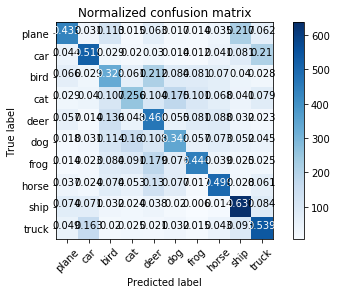

In [38]:
from sklearn.metrics import confusion_matrix

y_test_pred_mlp = model.predict(X_test_vectNorm)
Y_test_pred_mlp = np.argmax(y_test_pred_mlp, 1)

cnf_matrix_mlp = confusion_matrix(y_test, Y_test_pred_mlp)
print(cnf_matrix_mlp)
np.set_printoptions(precision=2)
plt.figure()
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(cnf_matrix_mlp, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

### 4.1.3 Test on single examples

(1, 3072)


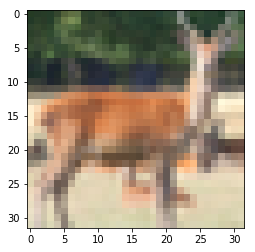

[[  4.13e-05   2.17e-05   3.24e-04   7.88e-05   5.22e-03   6.70e-05
    2.75e-05   8.75e-04   8.05e-07   2.53e-05]]
Prediction :  deer
Verité :  deer


In [45]:
def test_exemple(n):
    test = np.array([X_test_vectNorm[n]])
    print(test.shape)
    predict = model.predict_on_batch(test)
    plt.figure()
    plt.imshow(X_test_img[n])
    plt.show()
    print(predict)
    print("Prediction : ", class_names[np.argmax(predict)])
    print("Verité : ", class_names[int(y_test[n])])
    
test_exemple(1)
    

### 4.1.4 Remarques sur les résultats du MLP
Malgré la simplicité de l'architecture choisie, l'accuracy de ce MLP atteint presque 50% (sur le jeu d'entrainement). Son score le plus haut est sur les bateaux, ce qui peut s'expliquer par la présence d'eau et de ciel sur l'image, faciles à reconnaître (d'ailleurs, 20% des avions, qui ont du ciel, sont confondus avec les bateaux)
La classe la moins bien détectée est le chat, qui est souvent confondue avec les chiens, ce qui n'est pas étonnant, vue la basse résolution des images et les ressemblances entre ces animaux.

## 4.2 MLP classifier on HOG input

### 4.2.1 Training

In [16]:
import os
os.environ['KERAS_BACKEND']="tensorflow"
from keras.models import Sequential
from keras.layers import Dense, Activation

modelH = Sequential()
modelH.add(Dense(128, input_dim=324))
modelH.add(Activation('sigmoid'))
modelH.add(Dense(64))
modelH.add(Activation('sigmoid'))
modelH.add(Dense(10))
modelH.add(Activation('sigmoid'))

modelH.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

modelH.fit(XHog_train_img_norm, Y_train, epochs=400, batch_size=32)


Epoch 1/400
50000/50000 [==============================] - 2s - loss: 1.9866 - acc: 0.2559     
Epoch 2/400
50000/50000 [==============================] - 2s - loss: 1.6811 - acc: 0.4010     
Epoch 3/400
50000/50000 [==============================] - 2s - loss: 1.5680 - acc: 0.4467     
Epoch 4/400
50000/50000 [==============================] - 2s - loss: 1.5260 - acc: 0.4632     
Epoch 5/400
50000/50000 [==============================] - 2s - loss: 1.5018 - acc: 0.4711     
Epoch 6/400
50000/50000 [==============================] - 2s - loss: 1.4822 - acc: 0.4798     
Epoch 7/400
50000/50000 [==============================] - 2s - loss: 1.4666 - acc: 0.4869     
Epoch 8/400
50000/50000 [==============================] - 2s - loss: 1.4533 - acc: 0.4907     
Epoch 9/400
50000/50000 [==============================] - 2s - loss: 1.4421 - acc: 0.4945     
Epoch 10/400
50000/50000 [==============================] - 2s - loss: 1.4320 - acc: 0.4980     
Epoch 11/400
50000/50000 [=============

50000/50000 [==============================] - 2s - loss: 0.8560 - acc: 0.7034     
Epoch 169/400
50000/50000 [==============================] - 2s - loss: 0.8550 - acc: 0.7013     
Epoch 170/400
50000/50000 [==============================] - 2s - loss: 0.8538 - acc: 0.7033     
Epoch 171/400
50000/50000 [==============================] - 2s - loss: 0.8506 - acc: 0.7064     
Epoch 172/400
50000/50000 [==============================] - 2s - loss: 0.8494 - acc: 0.7049     
Epoch 173/400
50000/50000 [==============================] - 2s - loss: 0.8478 - acc: 0.7075     
Epoch 174/400
50000/50000 [==============================] - 2s - loss: 0.8461 - acc: 0.7048     
Epoch 175/400
50000/50000 [==============================] - 2s - loss: 0.8457 - acc: 0.7060     
Epoch 176/400
50000/50000 [==============================] - 2s - loss: 0.8430 - acc: 0.7071     
Epoch 177/400
50000/50000 [==============================] - 2s - loss: 0.8417 - acc: 0.7077     
Epoch 178/400
50000/50000 [=======

50000/50000 [==============================] - 2s - loss: 0.6352 - acc: 0.7824     
Epoch 335/400
50000/50000 [==============================] - 2s - loss: 0.6345 - acc: 0.7828     
Epoch 336/400
50000/50000 [==============================] - 2s - loss: 0.6337 - acc: 0.7827     
Epoch 337/400
50000/50000 [==============================] - 2s - loss: 0.6321 - acc: 0.7853     
Epoch 338/400
50000/50000 [==============================] - 2s - loss: 0.6325 - acc: 0.7839     
Epoch 339/400
50000/50000 [==============================] - 2s - loss: 0.6296 - acc: 0.7845     
Epoch 340/400
50000/50000 [==============================] - 2s - loss: 0.6286 - acc: 0.7854     
Epoch 341/400
50000/50000 [==============================] - 2s - loss: 0.6287 - acc: 0.7839     
Epoch 342/400
50000/50000 [==============================] - 2s - loss: 0.6275 - acc: 0.7862     
Epoch 343/400
50000/50000 [==============================] - 2s - loss: 0.6267 - acc: 0.7861     
Epoch 344/400
50000/50000 [=======

### 4.2.2 display confusion matrix MLP

[[582  16  93  31  49  24  21  15 149  20]
 [ 32 697  18  24  26  12  27  11  67  86]
 [ 61  10 528  66 119  70  74  24  39   9]
 [ 31  22 130 323 138 161  87  47  29  32]
 [ 19  13 115  87 552  66  48  48  31  21]
 [ 21   8 128 166  95 402  70  68  24  18]
 [ 22  13  87  57  93  61 613  17  30   7]
 [ 18  11  59  52 125 106  14 564  21  30]
 [100  61  26  24  27   7  16   7 689  43]
 [ 33  90  14  22  33  20   9  35  83 661]]
Normalized confusion matrix
[[ 0.58  0.02  0.09  0.03  0.05  0.02  0.02  0.01  0.15  0.02]
 [ 0.03  0.7   0.02  0.02  0.03  0.01  0.03  0.01  0.07  0.09]
 [ 0.06  0.01  0.53  0.07  0.12  0.07  0.07  0.02  0.04  0.01]
 [ 0.03  0.02  0.13  0.32  0.14  0.16  0.09  0.05  0.03  0.03]
 [ 0.02  0.01  0.12  0.09  0.55  0.07  0.05  0.05  0.03  0.02]
 [ 0.02  0.01  0.13  0.17  0.1   0.4   0.07  0.07  0.02  0.02]
 [ 0.02  0.01  0.09  0.06  0.09  0.06  0.61  0.02  0.03  0.01]
 [ 0.02  0.01  0.06  0.05  0.12  0.11  0.01  0.56  0.02  0.03]
 [ 0.1   0.06  0.03  0.02  0.03  0.01

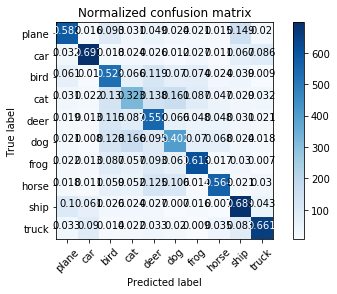

In [17]:
from sklearn.metrics import confusion_matrix

y_test_pred_mlp = modelH.predict(XHog_test_img_norm)
Y_test_pred_mlp = np.argmax(y_test_pred_mlp, 1)

cnf_matrix_mlp = confusion_matrix(y_test, Y_test_pred_mlp)
print(cnf_matrix_mlp)
np.set_printoptions(precision=2)
plt.figure()
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(cnf_matrix_mlp, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

### 4.2.3 Test on single examples

(1, 324)


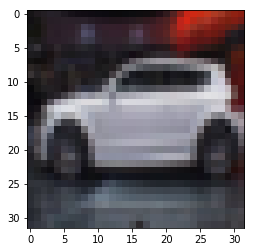

[[  8.67e-09   3.68e-03   3.18e-10   3.60e-08   4.35e-08   7.86e-10
    1.39e-09   2.85e-09   1.33e-07   4.57e-05]]
Prediction :  car
Verité :  car


In [36]:
def test_exemple_HOG(n):
    test = np.array([XHog_test_img_norm[n]])
    print(test.shape)
    predict = modelH.predict_on_batch(test)
    plt.figure()
    plt.imshow(X_test_img[n])
    plt.show()
    print(predict)
    print("Prediction : ", class_names[np.argmax(predict)])
    print("Verité : ", class_names[int(y_test[n])])
    
test_exemple_HOG(49)
    

### 4.2.4 Comparaison MLP sur image brut et sur le HOG
Les images HOG sont significativement plus petites que les images brutes, ce qui rend l'entrainement bien plus court (pour la même archtecture, on passe à moins de 1s par epoch). Cela nous permet de faire une architecture plus complexe, avec 2 couches cachées, qui au prix d'un entrainement plus long arrive à une précision de 60% (contre < 50% sur image brute). 

On remarque aussi que comme l'algorithme a tourné pendant bien plus longtemps, une accuracy de 80% a été atteinte sur le

Cependant, la dernière version stable de skimage ne permet de calculer le HOG que sur un seul canal : on gagne donc en reconnaissance de motifs, mais on perd les indications de couleur, qui permettait de distinguer assez efficacement les groupes (avions/bateaux) ( animaux) (vehicules terrestres) dans le MLP sur l'image brute.
Les classes les mieux détectées sont souvent les camions, bateaux et voitures, en général à 70%
La classe la moins bien détectée reste le chat, probablement pour les mêmes raisons. 


# 5. Conclusion
- **Algorithme des k plus proches voisins** : temps de calcul très long, et résultats plutôt médiocres
- **Forêts aléatoires** : les résultats sont tout de même meilleurs que le *kNN*, avec un temps d'exécution inférieur. Les résultats sont sensiblement identiques avec ou sans HOG, mais ceux-ci simplifient l'espace de calcul. Les résultats ne conviennent pas cependant pour une exploitation sérieuse.
- **Réseaux de neurones à couches** : Le temps d'entraînement est plus rapide (peut-être seulement à cause de l'utilisation de keras/tensorflow), et les résultats en terme de précision/rappel bien supérieurs. On pourrait cependant s'attendre à de meilleurs résultats avec des réseaux convolutionnels, qui déterminent eux-mêmes leurs features plutôt que d'utiliser un HOG sur la luminance de l'image.

